<a href="https://colab.research.google.com/github/ipediz/BachehayekhafaneTMU/blob/main/GRF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install sklearn
!pip install matplotlib
!pip install seaborn
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LinearRegression
%matplotlib inline


  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
Data = pd.read_csv(r'All_STATE_CASUAL_READY_2.csv')

In [ ]:
Data['Treatment'] = Data['Treatment'].replace({1: True, 0: False})

In [ ]:
from tabulate import tabulate
columns_to_drop = [
    'relative_time_m8andbeyond', 'relative_time_m7', 'relative_time_m6', 'relative_time_m5',
    'relative_time_m4', 'relative_time_m3', 'relative_time_m2', 'relative_time_m1', 'relative_time_0',
    'relative_time_p1', 'relative_time_p2', 'relative_time_p3', 'relative_time_p4',
    'relative_time_p5', 'relative_time_p6', 'relative_time_p7', 'relative_time_p8andbeyond',
    'cem_strata', 'cem_weights', 'nonbusiness_bankruptcy_percapita','business_bankruptcy_percapita', 'log_bankruptcy',
]


Data1= Data.drop(columns=columns_to_drop)
Data1 = Data1.dropna();

In [ ]:
T = "Treatment"
Y = "bankruptcy_per_capita"
X = ["population_estimation", "monthly_earnings", "medianhouseholdincome",
     "employed_individuals", "labor_force"]


In [ ]:
!pip install econml

In [ ]:
from econml.grf import CausalForest

In [ ]:

T = Data1["Treatment"].astype(int).values
Y = Data1["bankruptcy_per_capita"].values
X = Data1[["population_estimation", "monthly_earnings", "medianhouseholdincome",
           "employed_individuals", "labor_force"]].values  # Covariates as a 2D array

grf = CausalForest()

# Fit the model
grf.fit(X, T, Y)

# Extract HTEs (heterogeneous treatment effects)
hte_estimates = grf.predict(X)

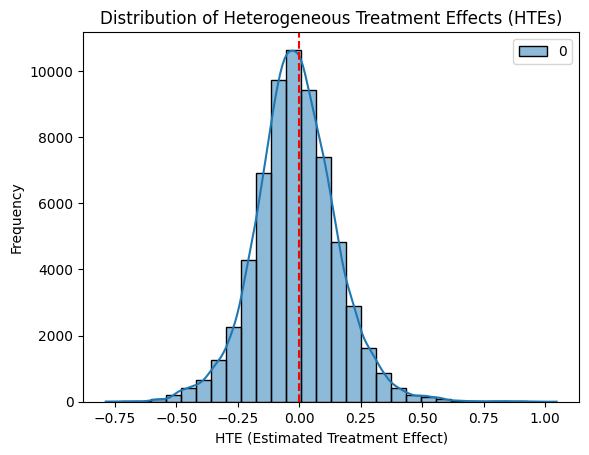

In [ ]:
# Create a histogram of the estimated HTEs
sns.histplot(hte_estimates, bins=30, kde=True)
plt.title("Distribution of Heterogeneous Treatment Effects (HTEs)")
plt.xlabel("HTE (Estimated Treatment Effect)")
plt.ylabel("Frequency")
plt.axvline(x=0, color='red', linestyle='--', label='Zero Effect')
plt.show()


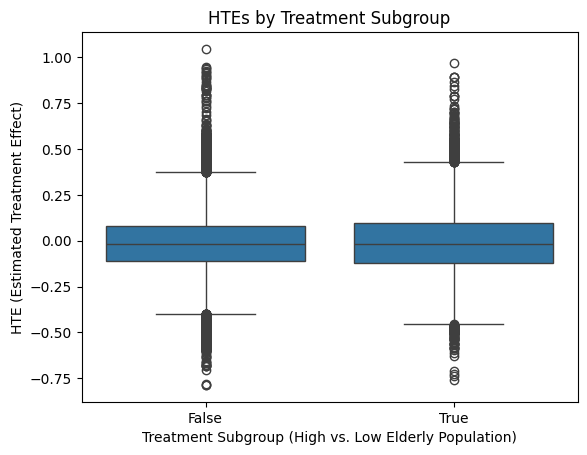

In [ ]:
# Assuming you have a column for subgroup labels (e.g., high or low elderly population)
Data1["HTE"] = hte_estimates  # Add the HTEs to the dataframe
sns.boxplot(x=Data1["Treatment"], y=Data1["HTE"])
plt.title("HTEs by Treatment Subgroup")
plt.xlabel("Treatment Subgroup (High vs. Low Elderly Population)")
plt.ylabel("HTE (Estimated Treatment Effect)")
plt.show()


In [ ]:
from econml.dml import CausalForestDML
from sklearn.linear_model import LogisticRegression, Lasso

# Define parameters
lambda_reg = 0.01  # Regularization parameter
subsample_ratio = 0.5  # Fraction of samples for bootstrapping

# Define outcome (Y), treatment (T), covariates (X), and weights (W)
Y = Data1["bankruptcy_per_capita"].values
T = Data1["Treatment"].astype(int).values
X = Data1[["population_estimation", "monthly_earnings", "medianhouseholdincome",
          "employed_individuals", "labor_force"]].values
W = None  # Or use Data["cem_weights"] if available

# Initialize the Causal Forest model
est2 = CausalForestDML(
    model_y=Lasso(alpha=lambda_reg),  # Outcome model
    model_t=LogisticRegression(C=1/(X.shape[0]*lambda_reg)),  # Propensity model
    n_estimators=200,  # Number of trees
    min_samples_leaf=5,  # Minimum samples per leaf
    max_depth=50,  # Maximum depth of trees
    max_samples=subsample_ratio / 2,  # Subsampling ratio
    discrete_treatment=True,  # Binary treatment
    random_state=123
)

# Fit the model
est2.fit(Y, T, X=X, W=W, cache_values=True)

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Grouping variable and control covariates
group_var = "county_code"  # Replace with your grouping variable
control_covariates = ["population_estimation", "monthly_earnings", "medianhouseholdincome",
                      "employed_individuals", "labor_force"]

# Generate a summary of the control covariates by group
group_stats = Data.groupby(group_var)[control_covariates].mean().reset_index()

# Split groups (counties) into train and test
train_groups, test_groups = train_test_split(
    group_stats[group_var],  # Use the grouping variable
    test_size=0.2,  # Adjust test size as needed
    random_state=123  # Reproducibility
)

# Create train and test datasets
train_data = Data1[Data1[group_var].isin(train_groups)]
test_data = Data1[Data1[group_var].isin(test_groups)]

# Check the split
print(f"Number of groups in train set: {len(train_groups)}")
print(f"Number of groups in test set: {len(test_groups)}")
print(f"Train data size: {train_data.shape}")
print(f"Test data size: {test_data.shape}")


Number of groups in train set: 1847
Number of groups in test set: 462
Train data size: (51551, 13)
Test data size: (12877, 13)


In [ ]:
# Define covariate columns
covariate_columns = ["population_estimation", "monthly_earnings",
                     "medianhouseholdincome", "employed_individuals", "labor_force"]

# Extract covariates for test set
X_test = test_data[covariate_columns].values  # Convert to NumPy array

# Check the shape of X_test
print(f"X_test shape: {X_test.shape}")


X_test shape: (12877, 5)


In [ ]:
treatment_effects2 = est2.effect(X_test)
te_lower2, te_upper2 = est2.effect_interval(X_test)

In [ ]:
est2.summary()

Population summary of CATE predictions on Training Data


<class 'econml.utilities.Summary'>
"""
               Uncertainty of Mean Point Estimate               
================================================================
mean_point stderr_mean zstat  pvalue ci_mean_lower ci_mean_upper
----------------------------------------------------------------
    -0.013       0.082 -0.154  0.878        -0.173         0.148
      Distribution of Point Estimate     
=========================================
std_point pct_point_lower pct_point_upper
-----------------------------------------
    0.133          -0.275           0.264
     Total Variance of Point Estimate     
==========================================
stderr_point ci_point_lower ci_point_upper
------------------------------------------
       0.156          -0.32          0.306
        Doubly Robust ATE on Training Data Results       
=========================================================
    point_estimate stderr zstat  pvalue ci_lower ci_upper
---------------------------------------------------------
ATE         -0.006  0.003 -1.875  0.061   -0.013      0.0
     Doubly Robust ATT(T=0) on Training Data Results     
=========================================================
    point_estimate stderr zstat  pvalue ci_lower ci_upper
---------------------------------------------------------
ATT          -0.01  0.003 -3.554    0.0   -0.016   -0.005
    Doubly Robust ATT(T=1) on Training Data Results     
========================================================
    point_estimate stderr zstat pvalue ci_lower ci_upper
--------------------------------------------------------
ATT          0.003  0.009 0.335  0.738   -0.014     0.02
--------------------------------------------------------

Note: The stderr_mean is a conservative upper bound.
"""

In [ ]:
from econml.sklearn_extensions.linear_model import WeightedLassoCVWrapper, WeightedLasso

# Helper imports
import numpy as np
from itertools import product
from sklearn.linear_model import Lasso, LogisticRegression
import matplotlib.pyplot as plt
from econml.orf import DMLOrthoForest, DROrthoForest
lambda_reg = 0.01
subsample_ratio = 0.4  # Adjust for your dataset size

# Initialize the DROrthoForest model
est = DROrthoForest(
    n_trees=200,                  # Number of trees
    min_leaf_size=10,             # Minimum samples per leaf
    max_depth=30,                 # Maximum depth of trees
    subsample_ratio=subsample_ratio,  # Subsampling ratio
    propensity_model=LogisticRegression(
        C=1/(X.shape[0]*lambda_reg), penalty='l1', solver='saga'
    ),  # Propensity model for treatment
    model_Y=Lasso(alpha=lambda_reg),  # Outcome model for Y
    propensity_model_final=LogisticRegression(
        C=1/(X.shape[0]*lambda_reg), penalty='l1', solver='saga'
    ),  # Final propensity model
    model_Y_final=WeightedLasso(alpha=lambda_reg)  # Final outcome model
)

In [ ]:
est.fit(Y, T, X=X, W=W)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  6.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   49.5s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  6.0min finished


In [ ]:
# Calculate treatment effects for the default treatment points T0=0 and T1=1
treatment_effects = est.effect(X_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 756 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done 2036 tasks      | elapsed:   59.7s
[Parallel(n_jobs=-1)]: Done 3828 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 6132 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 8948 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 12276 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 12877 out of 12877 | elapsed:  5.0min finished


In [ ]:
# Calculate default (95%) confidence intervals for the default treatment points T0=0 and T1=1
te_lower, te_upper = est.effect_interval(X_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 436 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 1076 tasks      | elapsed:   47.3s
[Parallel(n_jobs=-1)]: Done 1972 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3124 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 4532 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 6196 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 8116 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 10292 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 12724 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 12877 out of 12877 | elapsed:  8.8min finished


In [ ]:
group_var = "county_code"  # Replace this with your actual grouping column
T_column = "Treatment"  # Binary treatment column
Y_column = "bankruptcy_per_capita"  # Outcome column
T_train = train_data[T_column].values
Y_train = train_data[Y_column].values

groups = Data1[group_var].unique()

# Step 2: Split groups into train and test
train_groups, test_groups = train_test_split(groups, test_size=0.2, random_state=123)

# Step 3: Create train and test datasets based on the group split
train_data = Data1[Data1[group_var].isin(train_groups)]
test_data = Data1[Data1[group_var].isin(test_groups)]
T_test = test_data[T_column].values
Y_test = test_data[Y_column].values

# Print the results
print(f"Number of groups in train set: {len(train_groups)}")
print(f"Number of groups in test set: {len(test_groups)}")
print(f"Train data size: {train_data.shape}")
print(f"Test data size: {test_data.shape}")


Number of groups in train set: 1842
Number of groups in test set: 461
Train data size: (51524, 13)
Test data size: (12904, 13)


In [ ]:
from econml.dml import CausalForestDML
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Define treatment, outcome, and covariates
T = Data1['Treatment'].values  # Binary treatment
Y = Data1['bankruptcy_per_capita'].values  # Outcome
X = Data1[['population_estimation', 'monthly_earnings', 'medianhouseholdincome',
          'employed_individuals', 'labor_force']].values  # Covariates

# Split into train/test sets
X_train, X_test, T_train, T_test, Y_train, Y_test = train_test_split(
    X, T, Y, test_size=0.2, random_state=123
)

# Initialize and fit the causal forest
model = CausalForestDML(
    model_t=LogisticRegression(penalty='l2', solver='lbfgs'),  # Propensity model
    model_y=RandomForestRegressor(n_estimators=100),  # Outcome model
    discrete_treatment=True, random_state=123
)
model.fit(Y_train, T_train, X=X_train)

# Predict treatment effects
treatment_effects = model.effect(X_test)


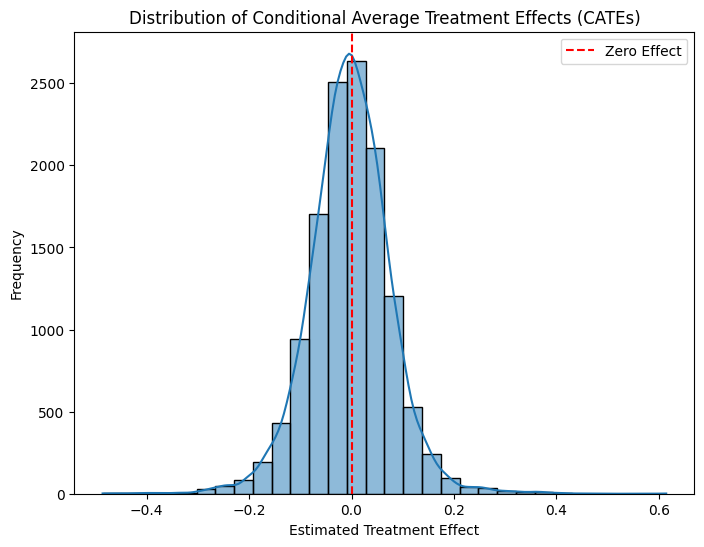

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.histplot(treatment_effects, kde=True, bins=30)
plt.title("Distribution of Conditional Average Treatment Effects (CATEs)")
plt.xlabel("Estimated Treatment Effect")
plt.ylabel("Frequency")
plt.axvline(x=0, color='red', linestyle='--', label="Zero Effect")
plt.legend()
plt.show()


In [ ]:
# Subset data for Lending Club availability = 1
lending_club_available = Data1[Data1['lending_club_available'] == 1]

# Add a high/low elderly population subgroup for Lending Club available data
lending_club_available['high_elderly'] = lending_club_available['percent_over_60'] >= lending_club_available['percent_over_60'].mean()

# Separate subgroups for Lending Club available data
high_elderly_lending_club = lending_club_available[lending_club_available['high_elderly']]
low_elderly_lending_club = lending_club_available[~lending_club_available['high_elderly']]

# Estimate treatment effects for subgroups in Lending Club available data
high_elderly_effects_lending_club = model.effect(high_elderly_lending_club[['population_estimation', 'monthly_earnings',
                                                                            'medianhouseholdincome', 'employed_individuals',
                                                                            'labor_force']])
low_elderly_effects_lending_club = model.effect(low_elderly_lending_club[['population_estimation', 'monthly_earnings',
                                                                          'medianhouseholdincome', 'employed_individuals',
                                                                          'labor_force']])

# Compare means for Lending Club available data
print("High Elderly Population (Lending Club Available) - Mean CATE:", high_elderly_effects_lending_club.mean())
print("Low Elderly Population (Lending Club Available) - Mean CATE:", low_elderly_effects_lending_club.mean())

# Subset data for Lending Club availability = 0
lending_club_not_available = Data1[Data1['lending_club_available'] == 0]

# Add a high/low elderly population subgroup for Lending Club not available data
lending_club_not_available['high_elderly'] = lending_club_not_available['percent_over_60'] >= lending_club_not_available['percent_over_60'].mean()

# Separate subgroups for Lending Club not available data
high_elderly_not_lending_club = lending_club_not_available[lending_club_not_available['high_elderly']]
low_elderly_not_lending_club = lending_club_not_available[~lending_club_not_available['high_elderly']]

# Estimate treatment effects for subgroups in Lending Club not available data
high_elderly_effects_not_lending_club = model.effect(high_elderly_not_lending_club[['population_estimation', 'monthly_earnings',
                                                                                    'medianhouseholdincome', 'employed_individuals',
                                                                                    'labor_force']])
low_elderly_effects_not_lending_club = model.effect(low_elderly_not_lending_club[['population_estimation', 'monthly_earnings',
                                                                                  'medianhouseholdincome', 'employed_individuals',
                                                                                  'labor_force']])

# Compare means for Lending Club not available data
print("High Elderly Population (Lending Club Not Available) - Mean CATE:", high_elderly_effects_not_lending_club.mean())
print("Low Elderly Population (Lending Club Not Available) - Mean CATE:", low_elderly_effects_not_lending_club.mean())


High Elderly Population (Lending Club Available) - Mean CATE: -0.005122123620392837
Low Elderly Population (Lending Club Available) - Mean CATE: -0.002667503963175947
High Elderly Population (Lending Club Not Available) - Mean CATE: -0.0011070273564790381
Low Elderly Population (Lending Club Not Available) - Mean CATE: -0.006660547228782465


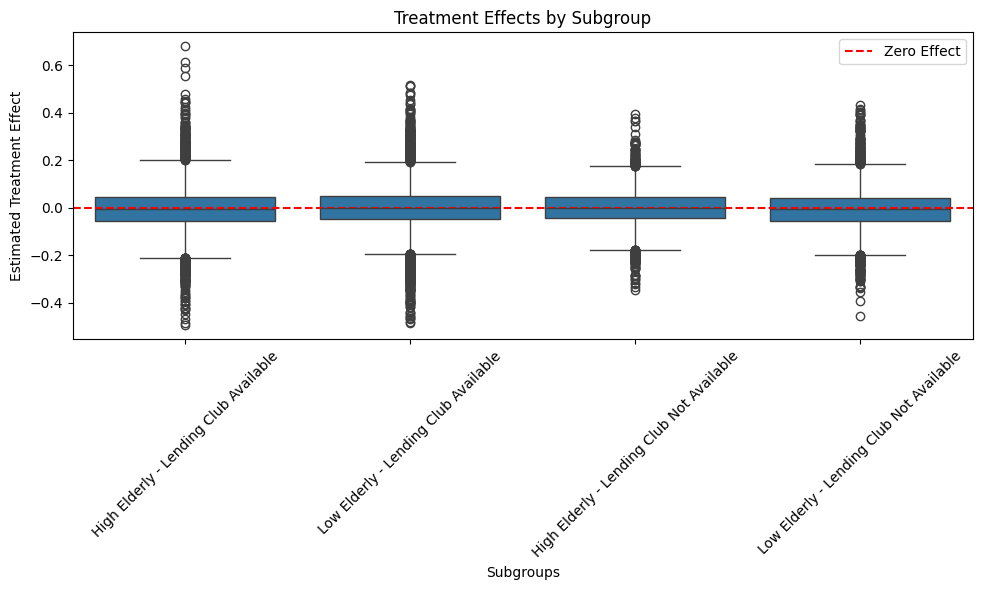

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Combine subgroup treatment effects for visualization
subgroup_effects = pd.DataFrame({
    'Treatment Effect': np.concatenate([
        high_elderly_effects_lending_club,
        low_elderly_effects_lending_club,
        high_elderly_effects_not_lending_club,
        low_elderly_effects_not_lending_club
    ]),
    'Subgroup': (['High Elderly - Lending Club Available'] * len(high_elderly_effects_lending_club) +
                 ['Low Elderly - Lending Club Available'] * len(low_elderly_effects_lending_club) +
                 ['High Elderly - Lending Club Not Available'] * len(high_elderly_effects_not_lending_club) +
                 ['Low Elderly - Lending Club Not Available'] * len(low_elderly_effects_not_lending_club))
})

# Plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=subgroup_effects, x='Subgroup', y='Treatment Effect')
plt.title("Treatment Effects by Subgroup")
plt.axhline(y=0, color='red', linestyle='--', label="Zero Effect")
plt.xticks(rotation=45)  # Rotate x-axis labels for clarity
plt.ylabel("Estimated Treatment Effect")
plt.xlabel("Subgroups")
plt.legend()
plt.tight_layout()
plt.show()


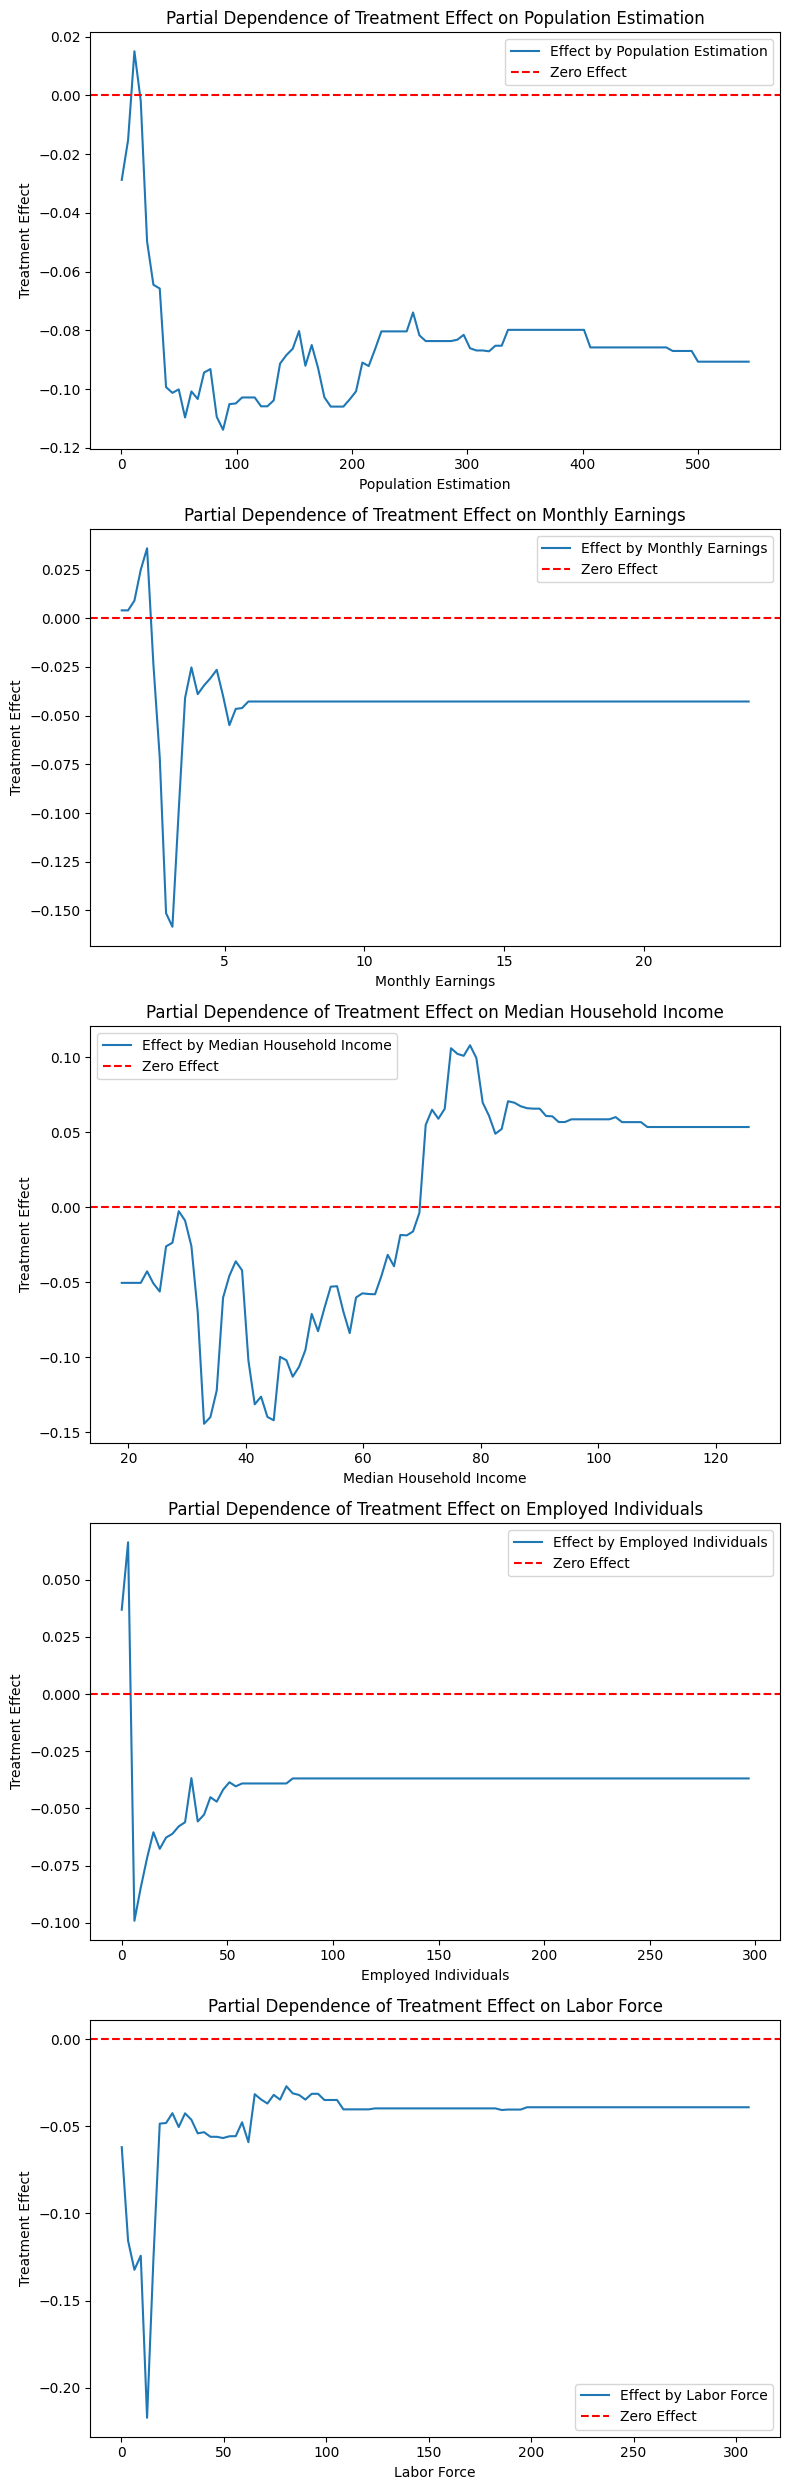

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the covariate columns and corresponding display names for the X-axis
covariate_columns = ['population_estimation', 'monthly_earnings', 'medianhouseholdincome',
                     'employed_individuals', 'labor_force']
covariate_display_names = {
    'population_estimation': 'Population Estimation',
    'monthly_earnings': 'Monthly Earnings',
    'medianhouseholdincome': 'Median Household Income',
    'employed_individuals': 'Employed Individuals',
    'labor_force': 'Labor Force'
}

# Compute medians for fixed values
fixed_values = Data1[covariate_columns].median().values

# Initialize the figure
num_covariates = len(covariate_columns)
fig, axes = plt.subplots(num_covariates, 1, figsize=(8, 5 * num_covariates), sharex=False)

# Loop through each covariate
for idx, covariate in enumerate(covariate_columns):
    grid_values = np.linspace(Data1[covariate].min(), Data1[covariate].max(), 100)

    # Prepare the input matrix for partial dependence
    partial_X = np.tile(fixed_values, (100, 1))
    partial_X[:, idx] = grid_values

    # Estimate treatment effects for the current covariate
    partial_effects = model.effect(partial_X)

    # Plot the partial dependence
    ax = axes[idx]
    ax.plot(grid_values, partial_effects, label=f"Effect by {covariate_display_names[covariate]}")
    ax.axhline(y=0, color='red', linestyle='--', label="Zero Effect")
    ax.set_title(f"Partial Dependence of Treatment Effect on {covariate_display_names[covariate]}")
    ax.set_xlabel(covariate_display_names[covariate])
    ax.set_ylabel("Treatment Effect")
    ax.legend()

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
feature_importances = model.feature_importances()
print("Feature Importances:", feature_importances)


Feature Importances: [0.13700304 0.2054019  0.2894796  0.16692512 0.20119034]


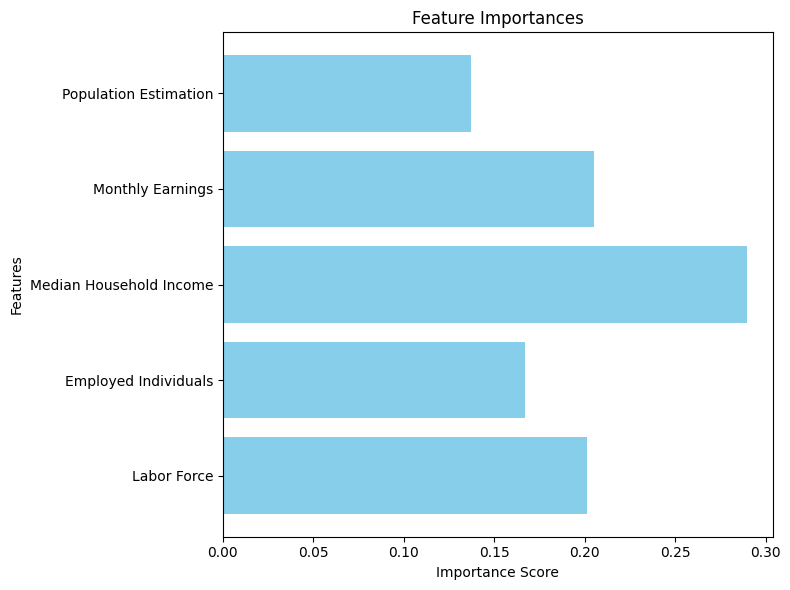

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Feature importance values
feature_importances = np.array([0.13700304, 0.2054019, 0.2894796, 0.16692512, 0.20119034])

# Feature names
feature_names = [
    'Population Estimation',
    'Monthly Earnings',
    'Median Household Income',
    'Employed Individuals',
    'Labor Force'
]

# Create a bar plot
plt.figure(figsize=(8, 6))
plt.barh(feature_names, feature_importances, color='skyblue')
plt.title("Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.gca().invert_yaxis()  # Invert Y-axis to display the most important feature at the top
plt.tight_layout()
plt.show()


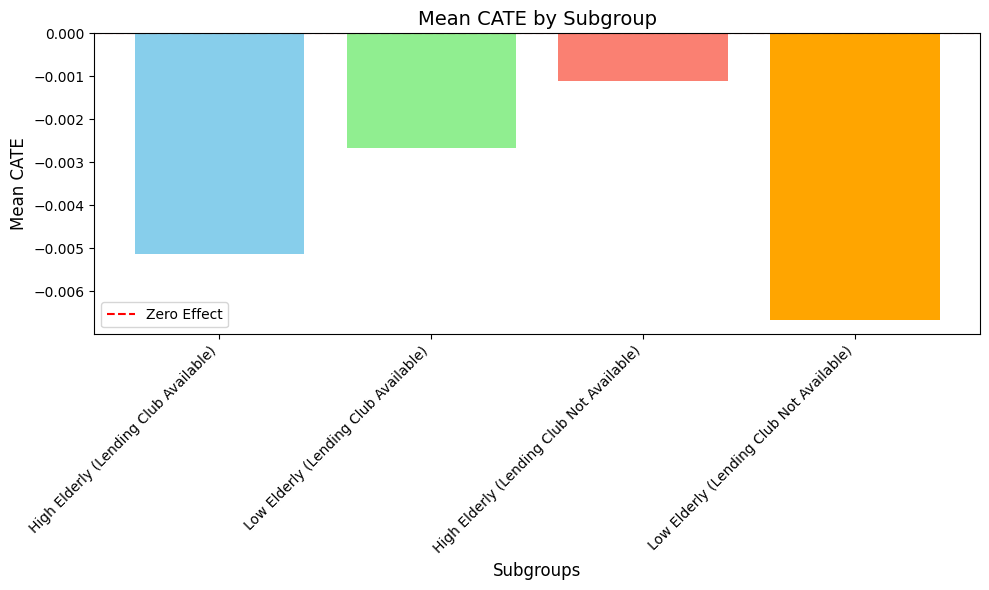

In [ ]:
import matplotlib.pyplot as plt

# Define the subgroups and their corresponding mean CATE values
subgroups = [
    "High Elderly (Lending Club Available)",
    "Low Elderly (Lending Club Available)",
    "High Elderly (Lending Club Not Available)",
    "Low Elderly (Lending Club Not Available)"
]
mean_cate_values = [-0.005122123620392837, -0.002667503963175947,
                    -0.0011070273564790381, -0.006660547228782465]

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(subgroups, mean_cate_values, color=['skyblue', 'lightgreen', 'salmon', 'orange'])
plt.axhline(y=0, color='red', linestyle='--', label='Zero Effect')

# Add labels and title
plt.title("Mean CATE by Subgroup", fontsize=14)
plt.xlabel("Subgroups", fontsize=12)
plt.ylabel("Mean CATE", fontsize=12)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()
